In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from training_flags import *
from Utilities.evaluation_utils import *
from DataPreparation.dataset_preparation import get_catsvsdogs_dataset
from GraphBuilder.model import Model

%matplotlib inline

# A. Loading the Dataset

### Getting started guide
* Set the data directory to the path where <b>either</b>: <br>
1- The following paths exist: trainset/Cat/, trainset/Dog/, testset/test/ <br>
2- The following numpy files exist: train_dataset.npy, train_labels.npy, X_test.npy <br>
* Determine the train-validation split ratio. A "validation_split" of 0.2 means that 20% of train_dataset will be used for validation and 80% of train_dataset will be used for training.<br>
* (Optional) Set a seed ("split_seed") for how validation and training get split up if you want to always split them the same way.<br>

### (Optional) Using another dataset
* If you want to read another dataset (other than catsvsdogs), you can try modifying dataset_preparation.py<br>
* If dataset images are not of size (64, 64, 3), or if you have more than 2 classes, you can change these parameters in training_flags.py

In [2]:
data_dir = 'Dataset/'
validation_split = 0.2
split_seed = 6135

### Load and check the size of the dataset
The data loaded here is used in test mode later. For training, data is loaded internally by the model object using this same get_catsvsdogs_dataset function defined in dataset_preparation.py.

In [3]:
X_train, y_train, X_val, y_val, X_test, X_train_moments = get_catsvsdogs_dataset(data_dir,
                                        validation_split, split_seed, normalize_train=True)
mean_img, std_img = X_train_moments
print('Train data size: ', X_train.shape)
print('Train labels size: ', y_train.shape)
print('Val data size: ', X_val.shape)
print('Val labels size: ', y_val.shape)
print('Test data size: ', X_test.shape)

Train data size:  (15999, 64, 64, 3)
Train labels size:  (15999,)
Val data size:  (3999, 64, 64, 3)
Val labels size:  (3999,)
Test data size:  (4999, 64, 64, 3)


### Set the Hyperparameters
* Change which model to use by changing "model" flag in training_flags.py (<b>NOTE:</b> Be sure to restart Jupyter Notebook Kernel for your change to take place (Shortcut: Press 0 twice))<br>
* Set the hyperparameters for training/loading the model by modifying hyperparameters "hparams" below.<br>
* We have provided two sets of hyperparameter for VGG19 and Wide28-10 that worked well for catsvsdogs.

In [4]:
### Good Hyperparameters for VGG19
if FLAGS.model is 'VGG19':
    hparams = tf.contrib.training.HParams(
        data_dir=data_dir,
        validation_split=validation_split,
        split_seed=split_seed,
        num_steps = 60000,
        lr = 3e-3, # 3e-3, 2e-4
        train_batch_size=64,
        eval_batch_size=64,
        dropout_probability=0.5,
        resume_training = False,
        optimizer='Momentum',
        cosine_lr = True,
        l2_scale = 3e-4, # 3e-4, 8e-4
        lr_decay_factor = 0.1,
        decay_steps = [-10]
        )
    print('VGG19 hyperparameters set.')
else:
    print('Did nothing.')

VGG19 hyperparameters set.


In [5]:
### Good Hyperparameters for Wide28-10
if FLAGS.model is 'Wide28_10':
    hparams = tf.contrib.training.HParams(
        data_dir=data_dir,
        validation_split=validation_split,
        split_seed=split_seed,
        num_steps=60000,
        lr=1e-2,
        train_batch_size=50,
        eval_batch_size=50,
        dropout_probability=0.5,
        resume_training=False,
        optimizer='Momentum',
        cosine_lr=True,
        l2_scale=1e-4,
        lr_decay_factor=0.1,
        decay_steps=[-10]
        )
    print('Wide28_10 hyperparameters set.')
else:
    print('Did nothing.')

Did nothing.


# B. Setting up the Model

### Hyperparameter search (Optional)
Random search for finding the optimal hyperparameters. If you are using the set of hyperparameters provided above, you can skip this.

In [6]:
# # hparams.l2_scale = 1e-12
# # hparams.num_steps = 1510
# # np.random.seed()
# for _ in range(100):
# #     hparams.lr = 10 ** np.random.uniform(-5, 0)
# #     hparams.l2_scale = 10 ** np.random.uniform(-5, -2)
#     tf.reset_default_graph()
#     model = Model(hparams)
#     print('lr: %.6f'%hparams.lr)
#     print('l2 reg: %.6f'%hparams.l2_scale)
#     model.train()

### Train (or Load) the model
Trains or loads the model depending on whether "hparams.resume_training" is True or False. If "hparams.resume_training" is True, it will load the model from "FLAGS.load_dir" directory and continue training until "hparams.num_steps" is reached.

In [7]:
tf.reset_default_graph()
model = Model(hparams) # Initialize Model object
train_history = model.train() # Start training
print('Training done!')

INFO:tensorflow:Restoring parameters from VGG19_logs/model.ckpt-60000
* Restored from checkpoint (VGG19_logs/): 60000 iterations
~~~ Training with /gpu:0 ~~~
Model: VGG19
Number of parameters: 45.23M
Training minibatch size: 64
Validation minibatch size: 64
Using data augmentation: True
~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Training done!


# C. Evaluating the Model

### 1- Inference Accuracy
Evaluates final accuracies on train and validation sets.

In [8]:
train_scores = model.test(X_train)
print('Train')
print('Accuracy: %.3f%%' % ((1-top1_error(train_scores, y_train)) * 100))
print('-------------')
val_scores = model.test(X_val)
print('Validation')
print('Accuracy: %.3f%%' % ((1-top1_error(val_scores, y_val)) * 100))

INFO:tensorflow:Restoring parameters from VGG19_logs/model.ckpt-60000
* Restored from checkpoint (VGG19_logs/): 60000 iterations
Train
Accuracy: 99.937%
-------------
INFO:tensorflow:Restoring parameters from VGG19_logs/model.ckpt-60000
* Restored from checkpoint (VGG19_logs/): 60000 iterations
Validation
Accuracy: 94.649%


### 2- Convergence

In [9]:
# # Save training history as a csv file
# save_history(train_history, hparams.num_steps, FLAGS.print_every)

In [10]:
# # Load training history csv
# train_history = read_history('Convergence_CSVs/Model_C.csv')

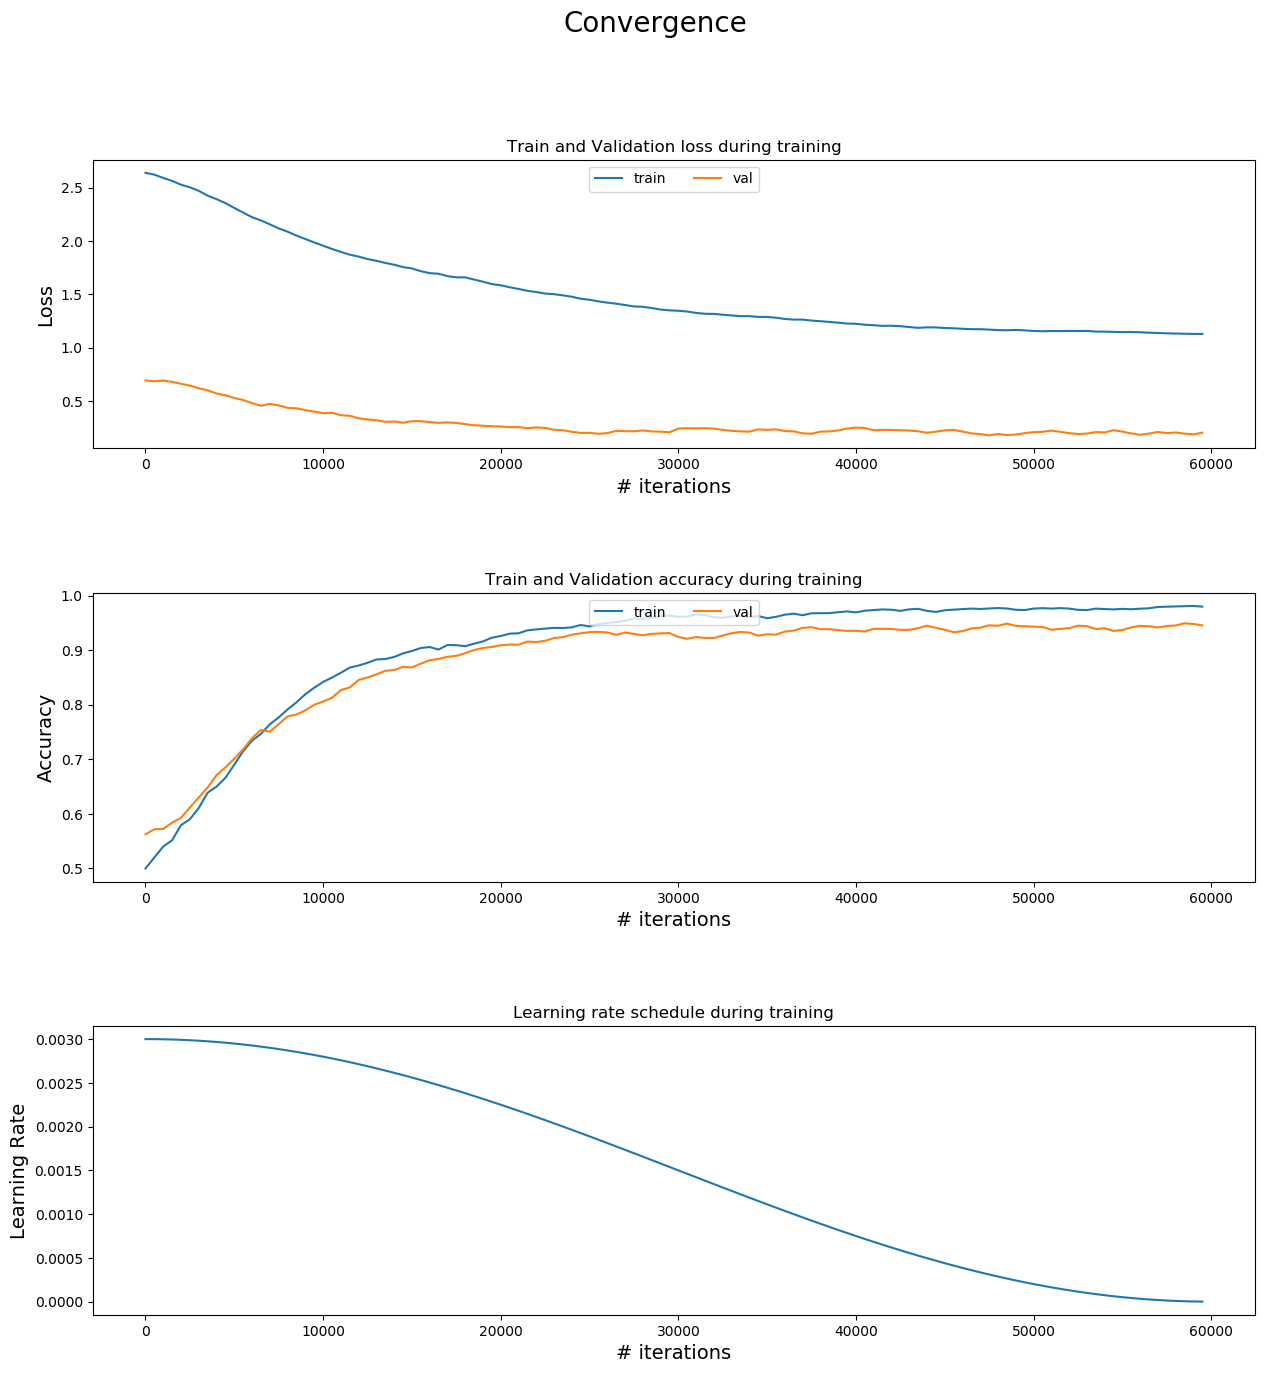

In [11]:
plt.rcParams.update(plt.rcParamsDefault)
steps = FLAGS.print_every * np.arange(len(train_history['lr_hist']))
fig, axes = plt.subplots(3, 1)
for i, measure in enumerate(['loss', 'error']):
    measure_figures = {'train':train_history['train_'+measure+'_hist'],
                    'val':train_history['val_'+measure+'_hist']}
    if measure == 'error': # convert top 1 error to accuracy
        measure_figures['train'] = [1-error for error in measure_figures['train']]
        measure_figures['val'] = [1-error for error in measure_figures['val']]
        
    ax = axes[i]
    for data_name, measure_history in list(measure_figures.items()):
        ax.plot(steps, MA(measure_history), label = data_name, rasterized=True)
        ax.set_xlabel('# iterations', size=14)
        ax.legend(loc='upper center', ncol=2)
        if measure == 'loss':
            ax.set_ylabel('Loss', size=14)
        else:
            ax.set_ylabel('Accuracy', size=14)

ax = axes[2]
ax.plot(steps, train_history['lr_hist'], label = 'Learning Rate', rasterized=True)
ax.set_xlabel('# iterations', size=14)

ax.set_ylabel('Learning Rate', size=14)
plt.gcf().set_size_inches(15, 15)
plt.subplots_adjust(hspace=0.5)
fig.suptitle('Convergence', size=20)
axes[0].title.set_text('Train and Validation loss during training')
axes[1].title.set_text('Train and Validation accuracy during training')
axes[2].title.set_text('Learning rate schedule during training')
plt.show()

### 3- Visualizing Classification results

* <b>Random Correct Classifications on Validation Set</b>

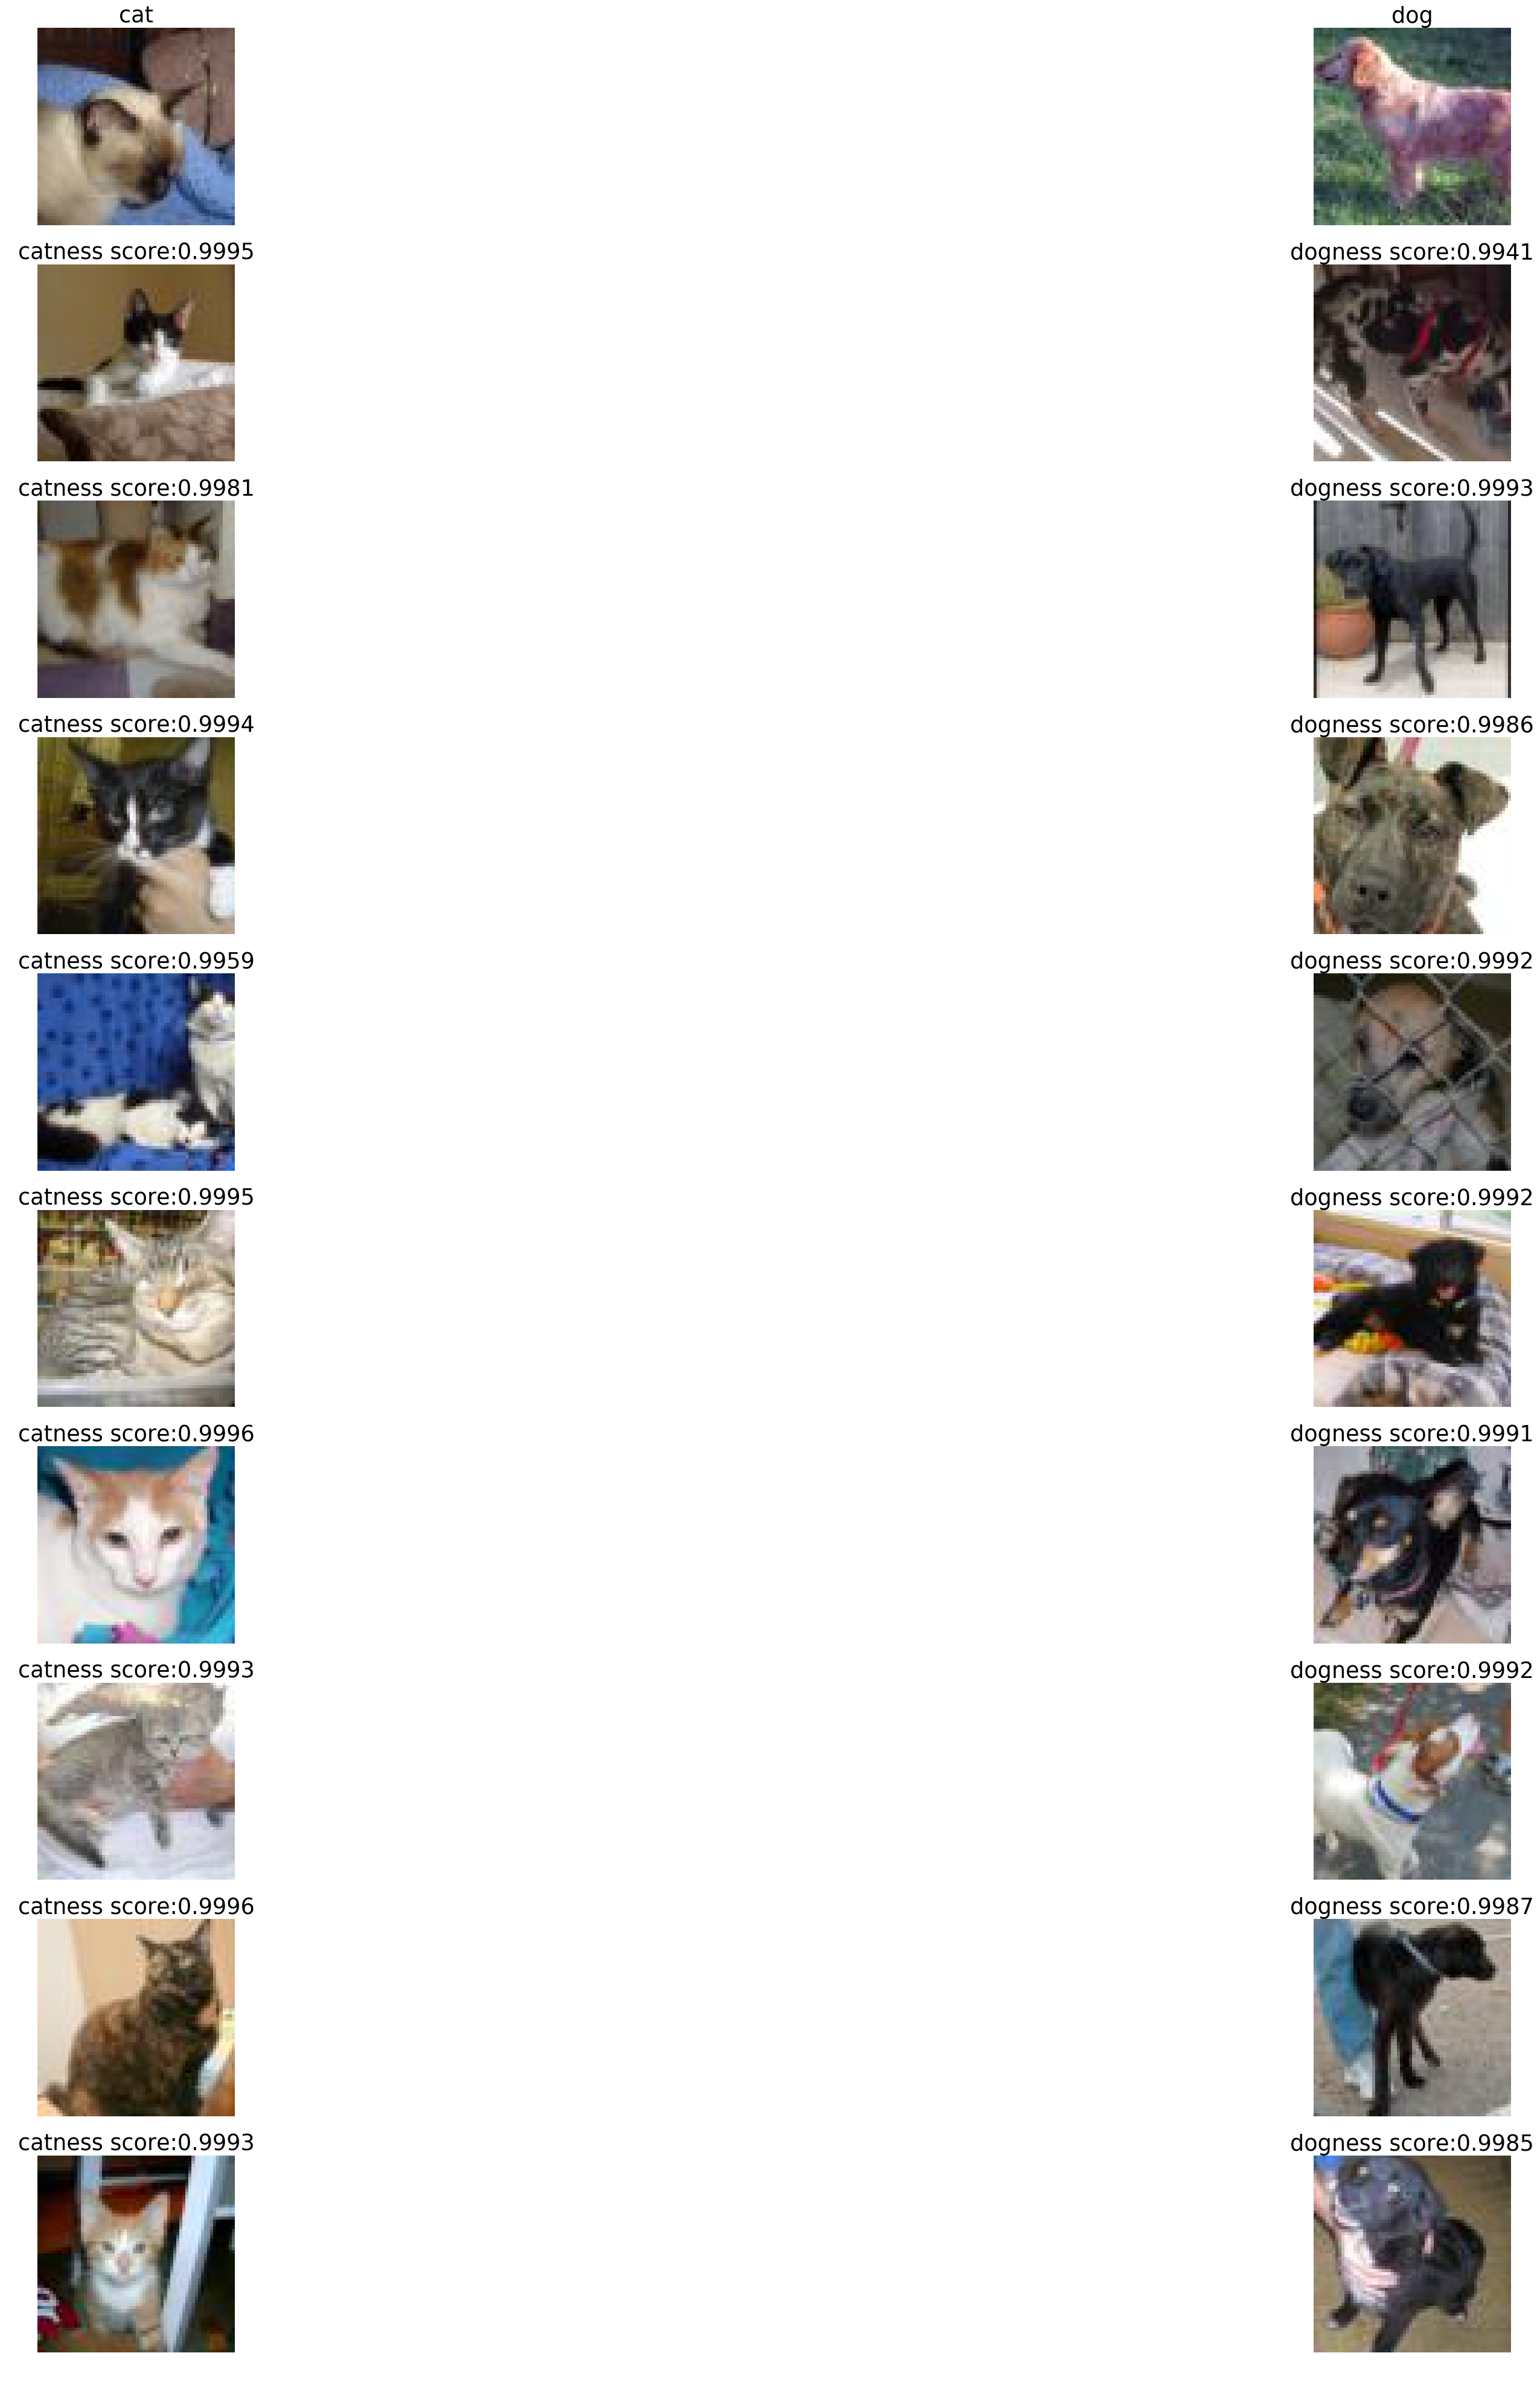

In [12]:
# Correct classifications
num_sample = 10

plt.rcParams['figure.figsize'] = [50, 50]
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 22}
plt.rc('font', **font)

predictions = softmax(val_scores)

y_preds = np.argmax(predictions, axis=1)
correct_preds = np.equal(y_preds, y_val)
correct_probs = predictions[correct_preds]
correct_images = X_val[correct_preds]

correct_preds = {'cat':[], 'dog':[]}
ind = np.arange(correct_images.shape[0])
ind_cat = ind[correct_probs[:,0] > 0.5]
ind_dog = ind[correct_probs[:,1] > 0.5]
np.random.shuffle(ind_cat)
np.random.shuffle(ind_dog)

correct_preds['cat'] = ind_cat[:num_sample]
correct_preds['dog'] = ind_dog[:num_sample]

classes = ['cat', 'dog']
num_classes = len(classes)
samples_per_class = num_sample
for y, cls in enumerate(classes):
    idxs = correct_preds[cls]
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        ax = plt.subplot(samples_per_class, num_classes, plt_idx)
        ax.set_title(cls+'ness score:'+str(np.round(correct_probs[idx,y], 4)))
        plt.imshow((mean_img+(std_img*correct_images[idx])).astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

* <b>Most Certain Misclassifications on Validation Set</b>

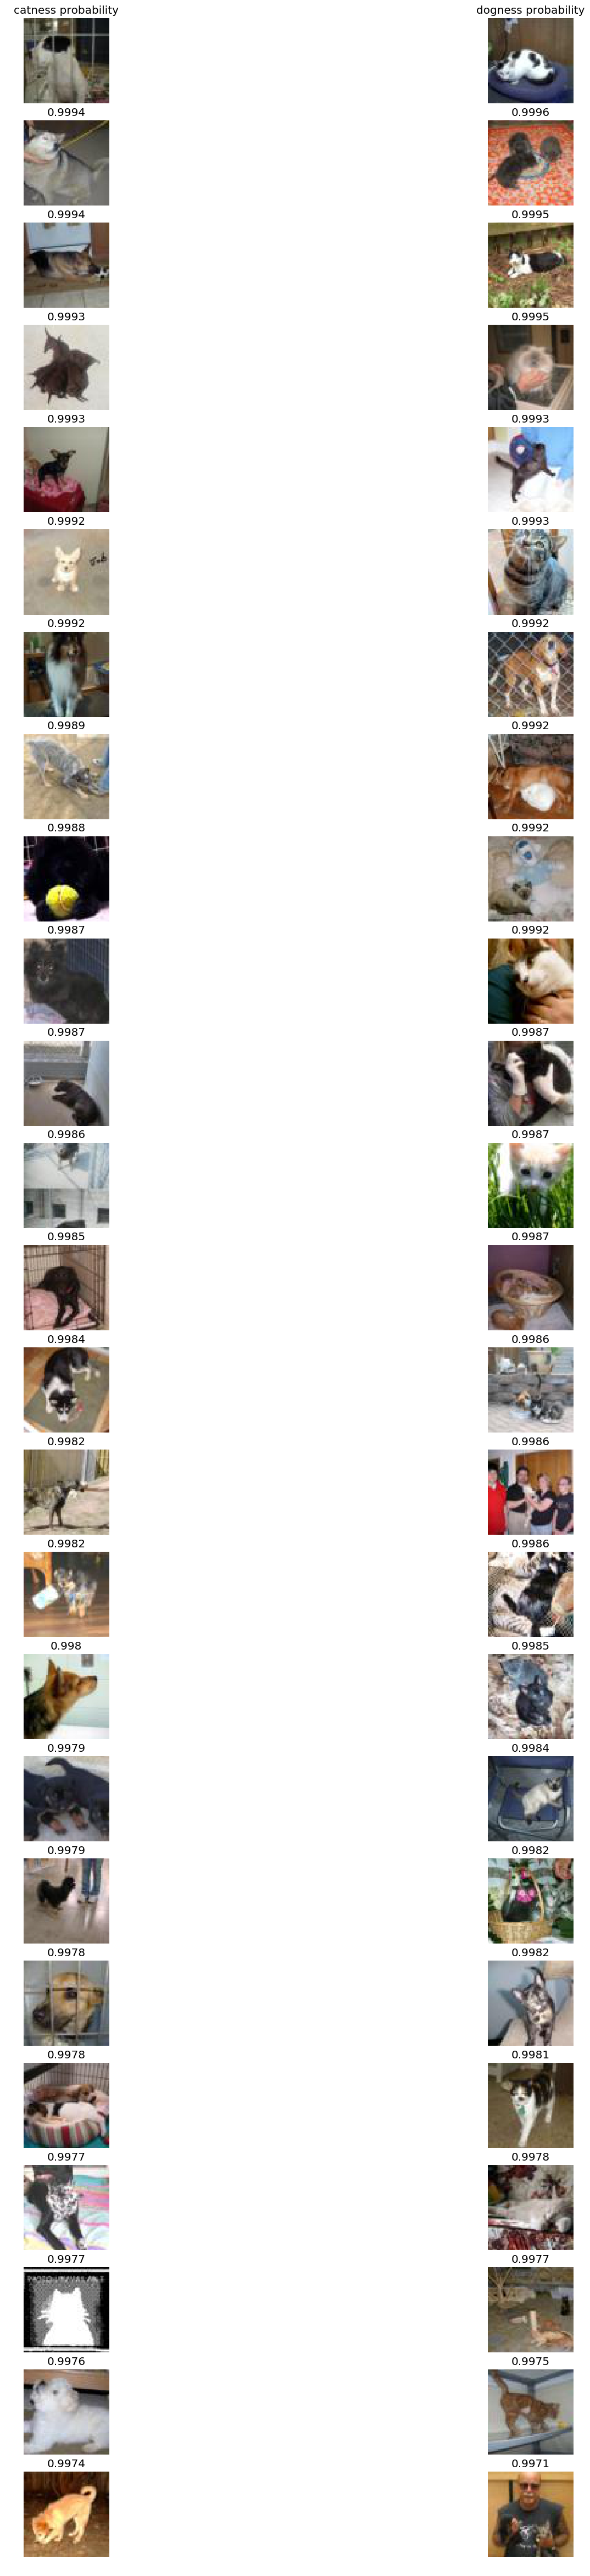

In [13]:
top_wrong = 25

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 12}
plt.rc('font', **font)

y_preds = np.argmax(predictions, axis=1)
wrong_preds = ~np.equal(y_preds, y_val)
wrong_probs = predictions[wrong_preds]
wrong_images = X_val[wrong_preds]

top_wrong_preds = {'cat':[], 'dog':[]}
top_wrong_preds['cat'] = wrong_probs[:,0].argsort()[-top_wrong:][::-1]
top_wrong_preds['dog'] = wrong_probs[:,1].argsort()[-top_wrong:][::-1]

plt.rcParams['figure.figsize'] = [20, 60]

classes = ['cat', 'dog']
num_classes = len(classes)
samples_per_class = top_wrong
for y, cls in enumerate(classes):
    idxs = top_wrong_preds[cls]
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        ax = plt.subplot(samples_per_class, num_classes, plt_idx)
        ax.set_title(str(np.round(wrong_probs[idx,y], 4)))
        img = (mean_img+(std_img*wrong_images[idx])).astype('uint8')
        plt.imshow(img)
        plt.axis('off')
        if i == 0:
            plt.title(cls+'ness probability')
plt.show()

* <b>Most Uncertain Misclassifications on Validation Set</b>

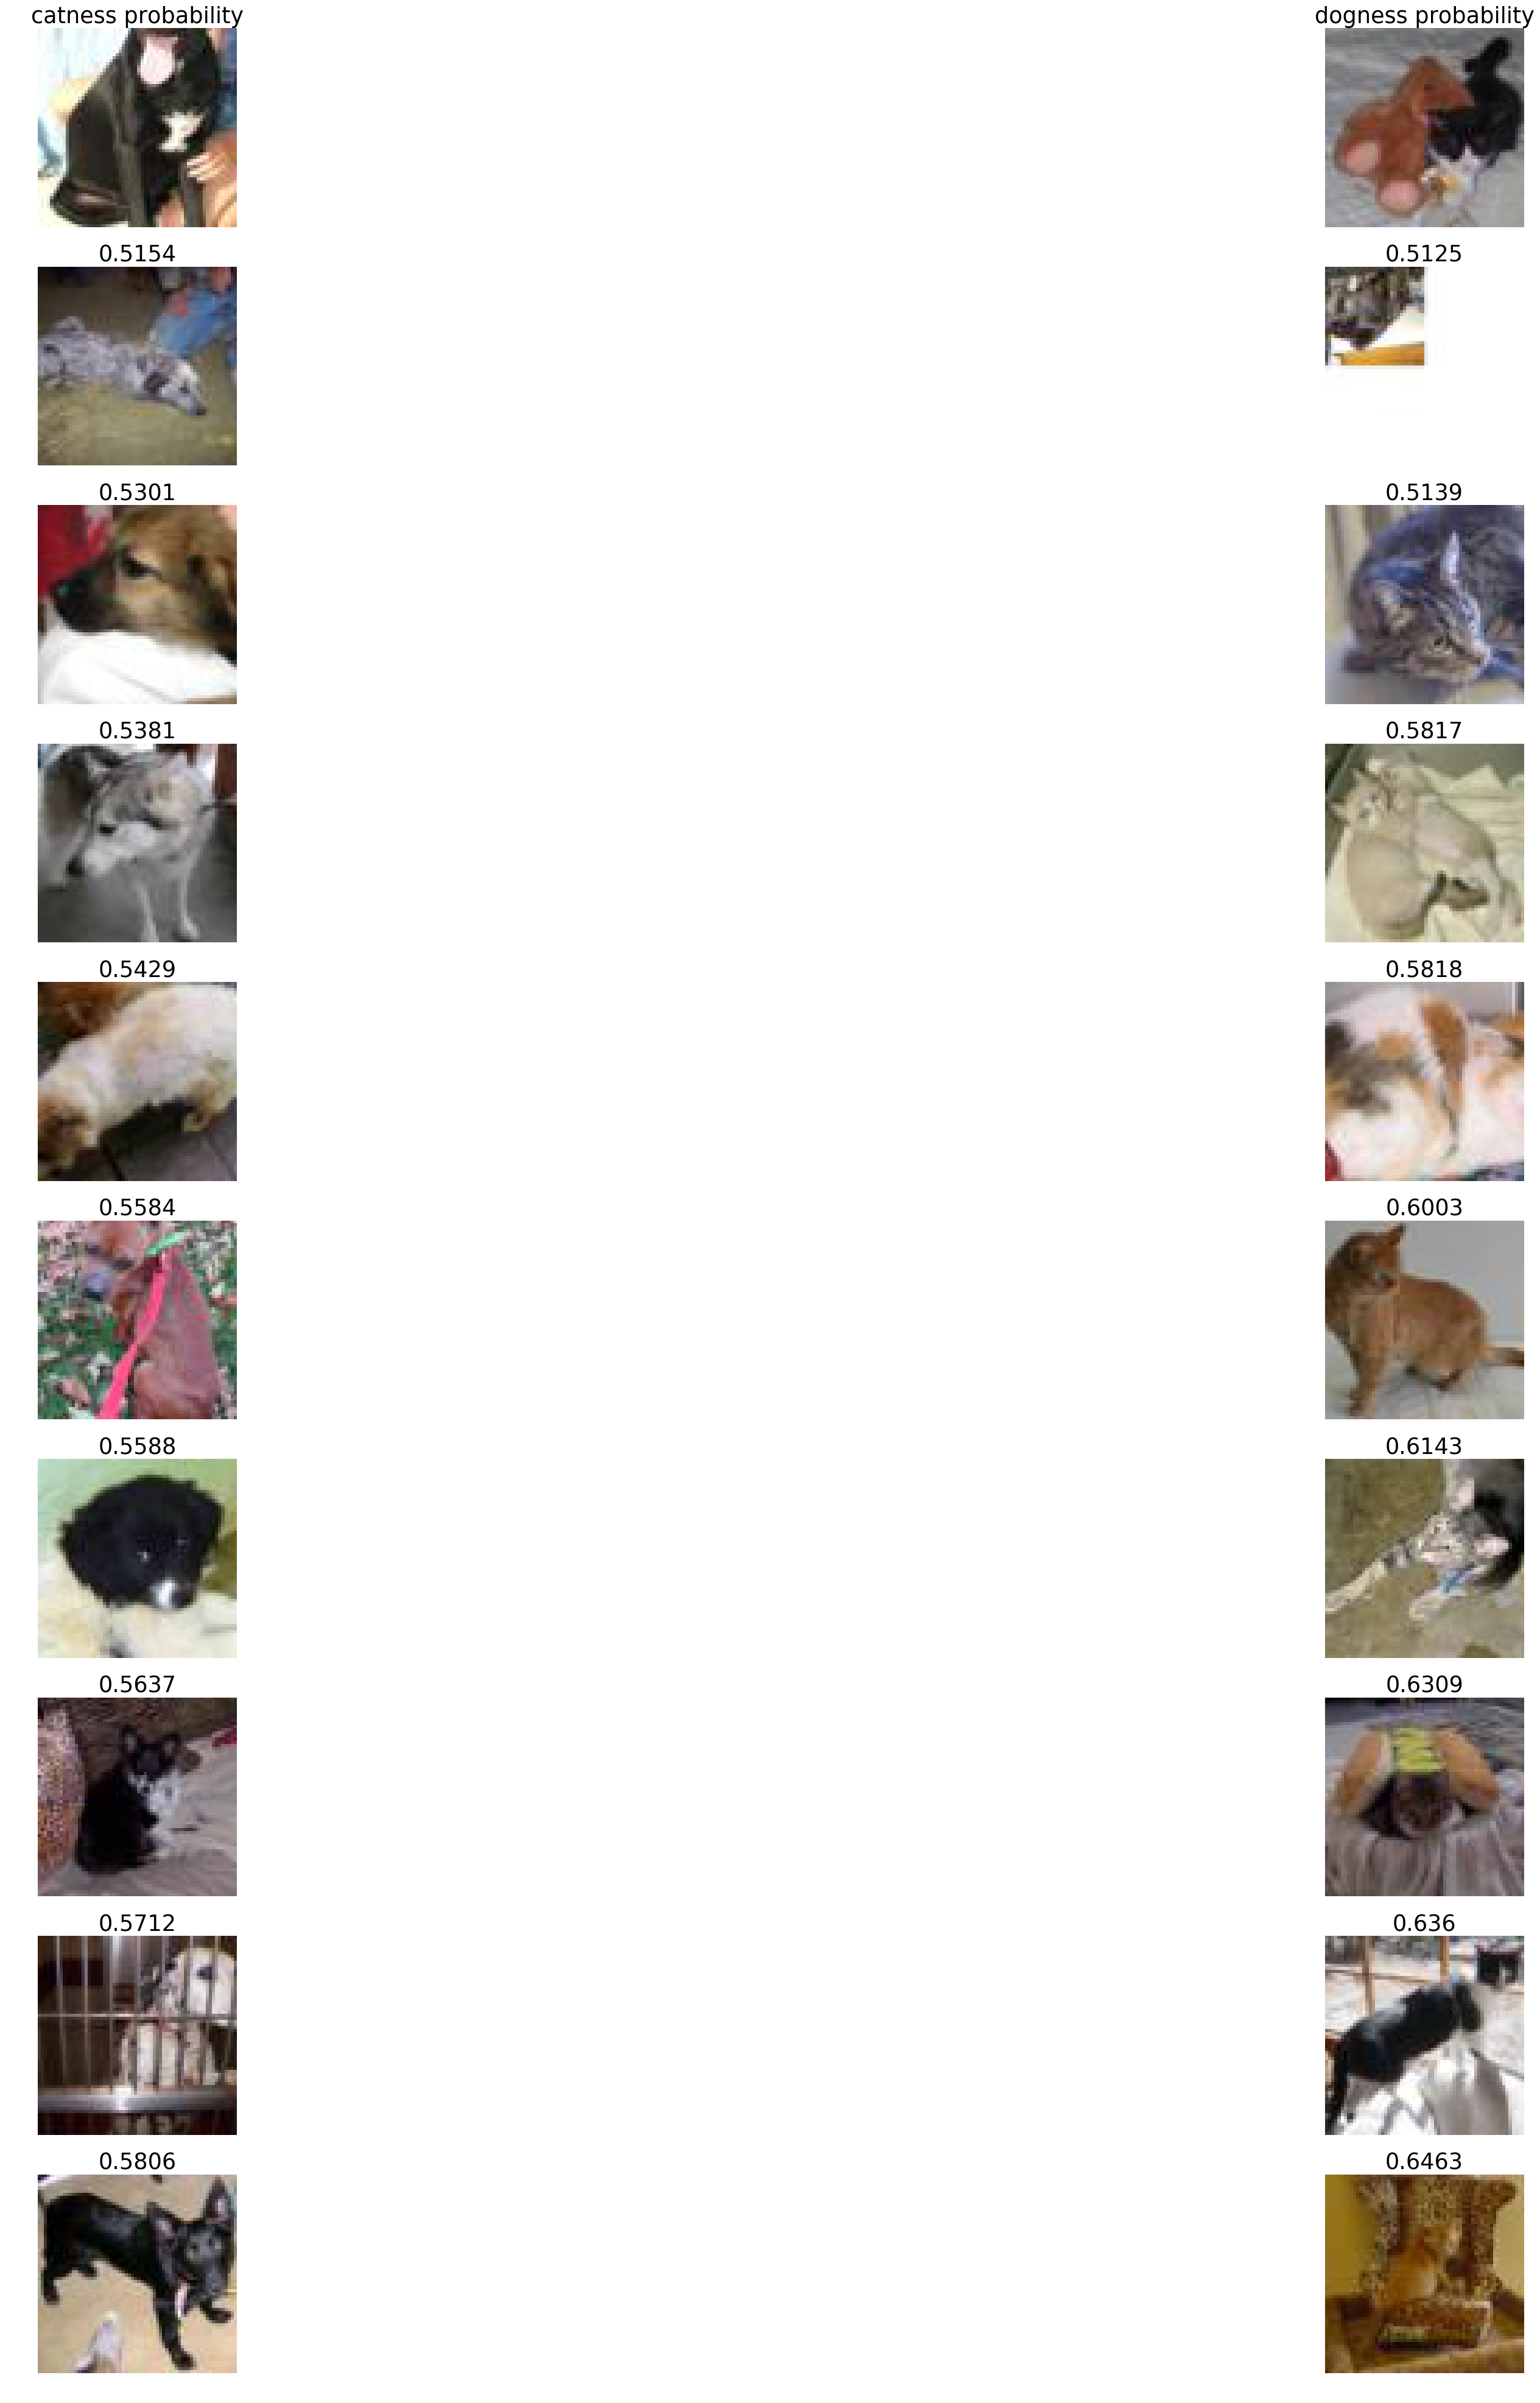

In [14]:
# Most uncertain misclassifications
top_wrong = 10

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 22}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = [50, 50]

y_preds = np.argmax(predictions, axis=1)
wrong_preds = ~np.equal(y_preds, y_val)
wrong_probs = predictions[wrong_preds]
wrong_images = X_val[wrong_preds]

editted_wrong_probs = wrong_probs.copy()
editted_wrong_probs[editted_wrong_probs<0.5] = 1000
top_wrong_preds = {'cat':[], 'dog':[]}
top_wrong_preds['cat'] = (editted_wrong_probs[:,0]-0.5).argsort()[:top_wrong]
top_wrong_preds['dog'] = (editted_wrong_probs[:,1]-0.5).argsort()[:top_wrong]

classes = ['cat', 'dog']
num_classes = len(classes)
samples_per_class = top_wrong
for y, cls in enumerate(classes):
    idxs = top_wrong_preds[cls]
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        ax = plt.subplot(samples_per_class, num_classes, plt_idx)
        ax.set_title(str(np.round(wrong_probs[idx,y], 4)))
        plt.imshow((mean_img+(std_img*wrong_images[idx])).astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls+'ness probability')
plt.show()

* <b>Most Uncertain Correct Classifications on Validation Set</b>

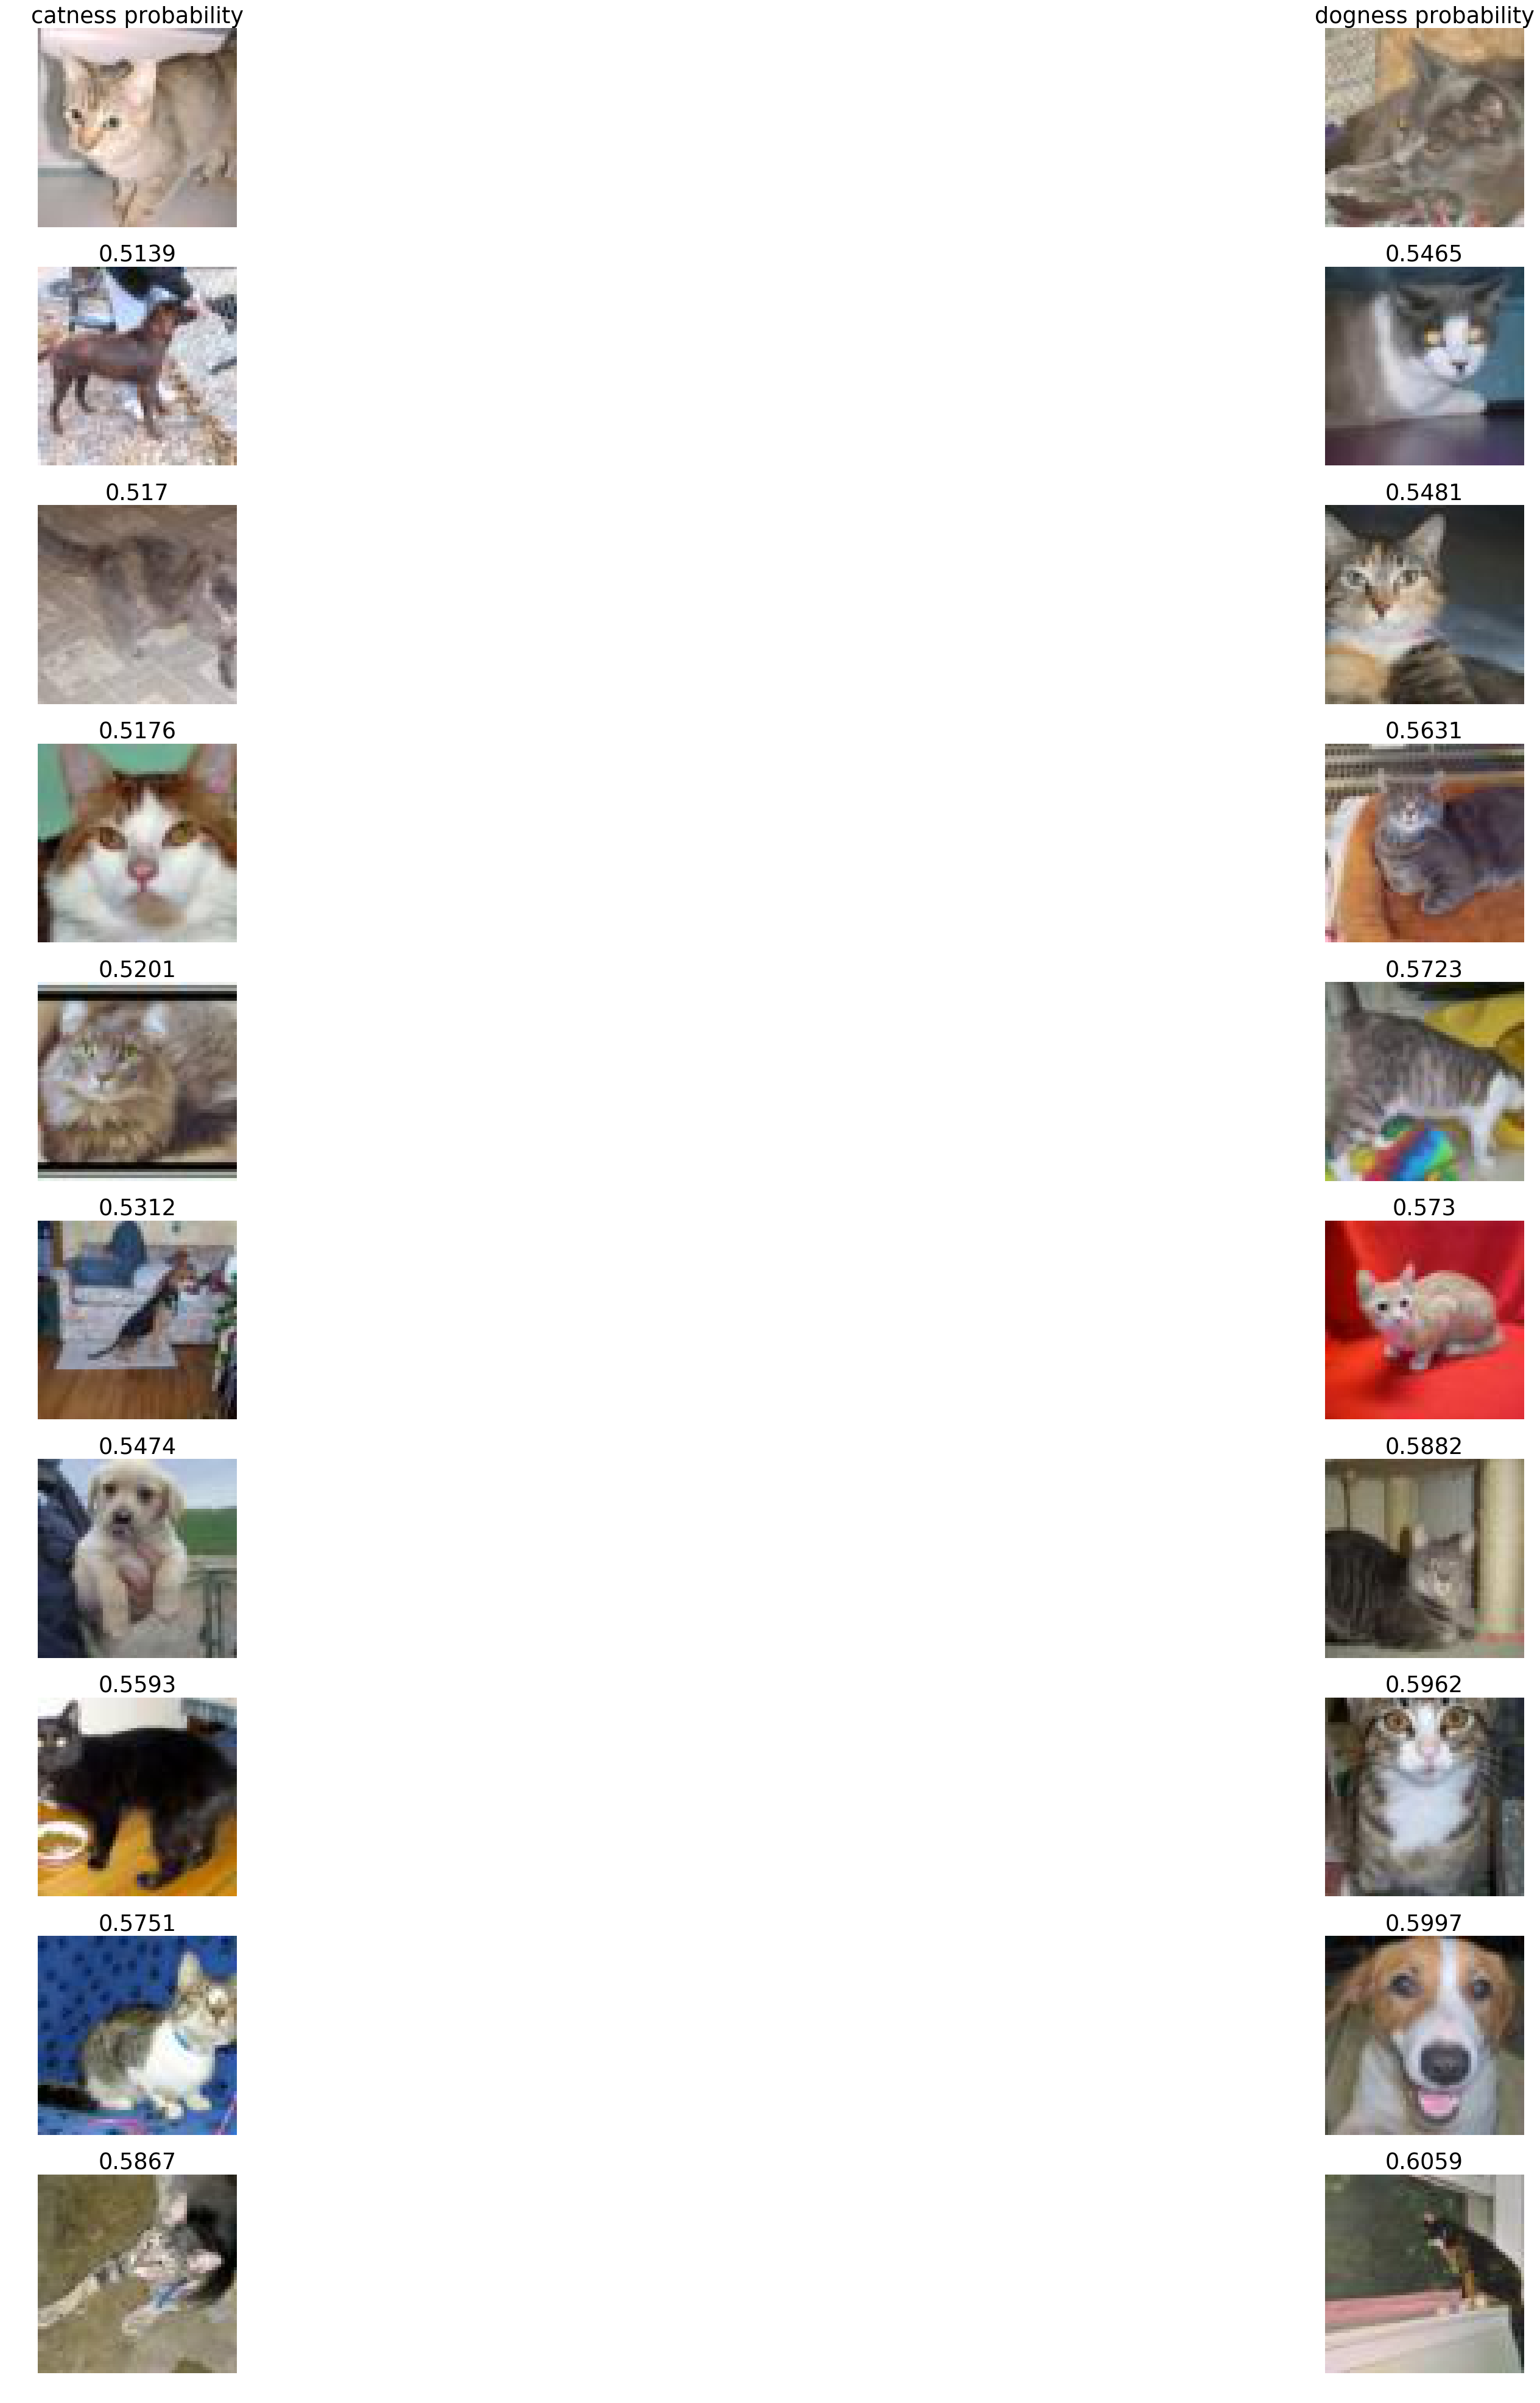

In [15]:
# Most uncertain classifications
top_uncertain = 10

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 22}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = [50, 50]

y_preds = np.argmax(predictions, axis=1)
correct_preds = np.equal(y_preds, y_val)
correct_probs = predictions[correct_preds]

editted_correct_probs = correct_probs.copy()
editted_correct_probs[editted_correct_probs<0.5] = 1000
top_uncertain_preds = {'cat':[], 'dog':[]}
top_uncertain_preds['cat'] = (editted_correct_probs[:,0]-0.5).argsort()[:top_uncertain]
top_uncertain_preds['dog'] = (editted_correct_probs[:,1]-0.5).argsort()[:top_uncertain]

classes = ['cat', 'dog']
num_classes = len(classes)
samples_per_class = top_uncertain
for y, cls in enumerate(classes):
    idxs = top_uncertain_preds[cls]
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        ax = plt.subplot(samples_per_class, num_classes, plt_idx)
        ax.set_title(str(np.round(correct_probs[idx,y], 4)))
        plt.imshow((mean_img+(std_img*X_val[idx])).astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls+'ness probability')
plt.show()

### 4- Classify Test Dataset
Get logits for test dataset.

In [16]:
test_scores = model.test(X_test)
print('Test set logits computed.')

INFO:tensorflow:Restoring parameters from VGG19_logs/model.ckpt-60000
* Restored from checkpoint (VGG19_logs/): 60000 iterations
Test set logits computed.


Store predictions for test dataset as csv file.

In [17]:
predictions = np.argmax(test_scores, axis=1)
labels = ['Cat', 'Dog']
save_predictions(predictions, labels, hparams.num_steps)

VGG19_preds_60000.csv saved.


Store probabilities for each label as csv file (for later use in ensembling models).

In [18]:
test_probabilities = softmax(test_scores)
save_probabilities(test_probabilities, labels, hparams.num_steps)

VGG19_probs_60000.csv saved.


In [19]:
val_probabilities = softmax(val_scores)
save_probabilities(val_probabilities, labels, f'val_{hparams.num_steps}')

VGG19_probs_val_60000.csv saved.
